In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [10]:
%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [11]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [5]:
columns_rename = {'time':'date_time','open':'first','high':'high','low':'low','close':'last','volume':'volume'}

In [42]:
def check_na(df):
    for col in df:
        print("count of NA values in",col,":",str(df[col].isnull().sum()))
        print("\n")

def check_unique(df):
    for col in df:
        print("unique values in",col,":",str(df[col].unique()))
        print("\n")
        
def convert_float(df,col_list):
    for i in col_list:
        df[i] = df[i].astype('float')

def intra_day():
    import pandas as pd
    import requests
    import csv
    # Prompt the user for input
    symbols = input('Enter symbols separated by commas: ').split(',')
    dfs = []
    for symbol in symbols:
        url = 'https://www.alphavantage.co/query'
        params = {
            'function': 'TIME_SERIES_INTRADAY',
            'symbol': symbol,
            'interval': '1min',
            'apikey': 'OX2BPYPUY81XL6PJ',
            'outputsize': 'full',  # Include full historical data
            'start_date': '2022-03-01',  # Set the start date
            'end_date': '2022-03-01'  # Set the end date
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            # Convert the data to a DataFrame
            df = pd.DataFrame.from_dict(data['Time Series (1min)'], orient='index')
            df = df.reset_index()
            df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.sort_values('datetime')
            df['symbol'] = symbol  # Add a new column with the symbol
            df['fwd1min'] = df['close'].shift(-1)  # Add a new column with the 1-minute forward price
            dfs.append(df)
        else:
            print(f'Request failed with status code {response.status_code}')
    data = pd.concat(dfs, ignore_index = True)
    return(data)
    
def api_intra_day_extended(symbol):
    import requests
    import csv
    import pandas as pd
    
    #print(symbols)
    year = [1, 2]
    months = list(range(1, 13))
    permutations = len(year) * len(months)
    i = 1
    
    dfs = []
    for y in year:
        for m in months:
            print('------------------ progress:' + str(round(i*100/permutations,0)) + '% ------------------')
            i += 1
            url = 'https://www.alphavantage.co/query'
            slice_key = 'year'+str(y)+'month'+str(m)
            params = {
                'function': 'TIME_SERIES_INTRADAY_EXTENDED',
                'symbol': symbol,
                'interval': '1min',
                'apikey': 'TDJCJMSABXYSLRSP',
                'slice': slice_key
                #'outputsize': 'full',  # Include full historical data
            }
            response = requests.get(url, params=params)
    
            with requests.Session() as s:
                download = s.get(url,params=params)
                decoded_content = download.content.decode('utf-8')
                cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                data = list(cr)
                df = pd.DataFrame(data[1:], columns=data[0])  # Create pandas DataFrame
                #print(slice_key)
                #print(pd.DataFrame(df).head(1))
                #print(pd.DataFrame(df).tail(1))
                #print('\n')
                df['ticker'] = symbol  # Add symbol column to DataFrame
                dfs.append(df)  # Append DataFrame to list of DataFrames
    
    data = pd.concat(dfs)  # Combine list of DataFrames into one DataFrame
    return(data)

def get_dataset():
    dfs_raw = []
    symbols = input('Enter symbols separated by commas: ').split(',')
    for i in symbols:
        print('----------------- ',i,': ----------------- ')
        dfs_raw.append(api_intra_day_extended(i))
        
    data = pd.concat(dfs_raw)  # Combine list of DataFrames into one DataFrame
        
    ## ADD DATA SANITY CHECKS HERE:
    # Comparison of total days vs. days fetched.
    # Comparison of count before and after dropping NAs. 
        
    data = (data.dropna()
            .rename(columns=columns_rename))
    #data['datetime'] = pd.to_datetime(data['datetime'])
    #data['date'] = data['datetime']
    convert_float(data,['first','low','last','volume','high'])
    data = (data.set_index(['date_time'])
           .sort_index()
           .set_index('ticker', append=True)
           .swaplevel())
    data = data.dropna()
    data = data.apply(pd.to_numeric, downcast='integer')
    
    return(data)

In [43]:
df = get_dataset()

Enter symbols separated by commas: GOOGL,MSFT
-----------------  GOOGL : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
---------

In [44]:
df.info()
## issue: returning only 1 years data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('MSFT', '2021-04-19 04:03:00') to ('GOOGL', '2023-04-06 20:00:00')
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   first   551458 non-null  float64
 1   high    551458 non-null  float64
 2   low     551458 non-null  float64
 3   last    551458 non-null  float64
 4   volume  551458 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 32.1+ MB


In [46]:
df = df.reset_index()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date.astype('datetime64[ns]')
df = (df.set_index(['date_time'])
           .sort_index()
           .set_index('ticker', append=True)
           .swaplevel())

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 551458 entries, ('MSFT', Timestamp('2021-04-19 04:03:00')) to ('GOOGL', Timestamp('2023-04-06 20:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   first   551458 non-null  float64       
 1   high    551458 non-null  float64       
 2   low     551458 non-null  float64       
 3   last    551458 non-null  float64       
 4   volume  551458 non-null  int32         
 5   date    551458 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 36.3+ MB


In [48]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

In [49]:
data = pd.DataFrame(index=df.index)

In [50]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [51]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

In [52]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

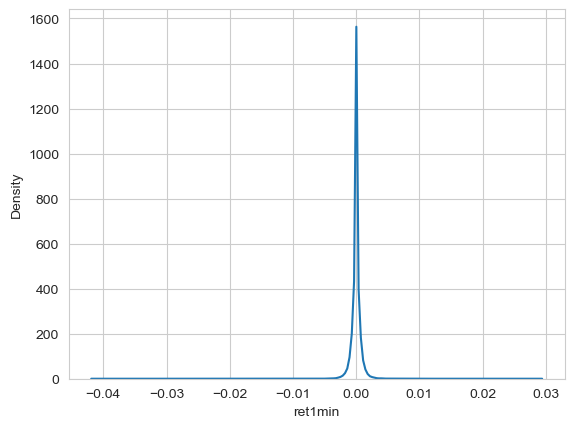

In [53]:
sns.kdeplot(data.ret1min.sample(n=100000));

In [54]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean    -0.000%
std      0.082%
min     -4.235%
10%     -0.070%
20%     -0.036%
30%     -0.016%
40%     -0.001%
50%      0.000%
60%      0.000%
70%      0.016%
80%      0.035%
90%      0.069%
max      4.637%
Name: ret1min, dtype: object

In [55]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

date  minute   ret1min       first        last
ticker date_time                                                          
GOOGL  2021-04-27 17:02:00     6     781  0.046369  114.549000  119.860500
MSFT   2022-07-26 18:05:00   320     844  0.041783  248.956645  259.358789
GOOGL  2023-02-01 16:40:00   451     759  0.039032  100.430000  104.350000
MSFT   2021-04-27 17:02:00     6     781  0.036725  248.178888  257.293218
GOOGL  2022-11-10 08:31:00   396     270  0.031963   87.600000   90.400000
MSFT   2022-12-13 08:31:00   418     270  0.030895  256.352741  264.272744
       2022-06-02 09:04:00   284     303  0.029173  266.068568  273.830473
       2022-03-09 08:01:00   225     240  0.029001  273.134201  281.055439
       2023-01-24 16:02:00   445     721  0.028798  241.420443  248.372889
GOOGL  2022-02-01 16:06:00   200     725  0.028571  140.000000  144.000000

In [56]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:39<00:00,  4.41s/it]


In [57]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [58]:
data = data.dropna(subset=['fwd1min'])

In [59]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550464 entries, ('MSFT', Timestamp('2021-04-19 04:03:00')) to ('MSFT', Timestamp('2023-04-06 19:59:00'))
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      550464 non-null  int64  
 1   minute    550464 non-null  int32  
 2   ret1min   550464 non-null  float64
 3   ret2min   549470 non-null  float64
 4   ret3min   548476 non-null  float64
 5   ret4min   547482 non-null  float64
 6   ret5min   546488 non-null  float64
 7   ret6min   545494 non-null  float64
 8   ret7min   544500 non-null  float64
 9   ret8min   543506 non-null  float64
 10  ret9min   542512 non-null  float64
 11  ret10min  541518 non-null  float64
 12  fwd1min   550464 non-null  float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 65.7+ MB


In [60]:
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x['first'],
                                                   x.high,
                                                   x.low,
                                                   x['last'])))

In [61]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14)))

In [62]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)))

In [63]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,550464.000000,550438.000000,5.504360e+05
mean,-0.001827,0.772574,5.010147e+01
std,0.606217,107.915592,1.951378e+01
min,-1.000000,-466.666667,-1.200877e-11
10%,-0.906250,-136.465806,2.442991e+01
20%,-0.619469,-98.537773,3.290855e+01
30%,-0.344949,-67.907820,3.932852e+01
40%,-0.031746,-35.523718,4.486837e+01
50%,0.000000,1.752819,5.012027e+01
60%,0.015131,38.203302,5.536636e+01


In [64]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'].ffill(),
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

In [65]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high.ffill(), x.low.ffill(), x['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
    return pd.DataFrame({'slowd': slowd, 
                         'slowk': slowk}, 
                        index=x.index)

In [66]:
data = data.join(by_ticker.apply(compute_stoch))

In [67]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high.ffill(), 
                                                    x.low.ffill(), 
                                                    x['last'].ffill()))

In [ ]:
del df

In [68]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550464 entries, ('MSFT', Timestamp('2021-04-19 04:03:00')) to ('MSFT', Timestamp('2023-04-06 19:59:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      550464 non-null  int64  
 1   minute    550464 non-null  int32  
 2   ret1min   550464 non-null  float64
 3   ret2min   549470 non-null  float64
 4   ret3min   548476 non-null  float64
 5   ret4min   547482 non-null  float64
 6   ret5min   546488 non-null  float64
 7   ret6min   545494 non-null  float64
 8   ret7min   544500 non-null  float64
 9   ret8min   543506 non-null  float64
 10  ret9min   542512 non-null  float64
 11  ret10min  541518 non-null  float64
 12  fwd1min   550464 non-null  float64
 13  BOP       550464 non-null  float64
 14  CCI       550438 non-null  float64
 15  MFI       550436 non-null  float64
 16  STOCHRSI  550406 non-null  float64
 17  slowd     550430 non-null  float64
 18  slowk  

In [71]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min','BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd']

In [72]:
sample = data.sample(n=100000)

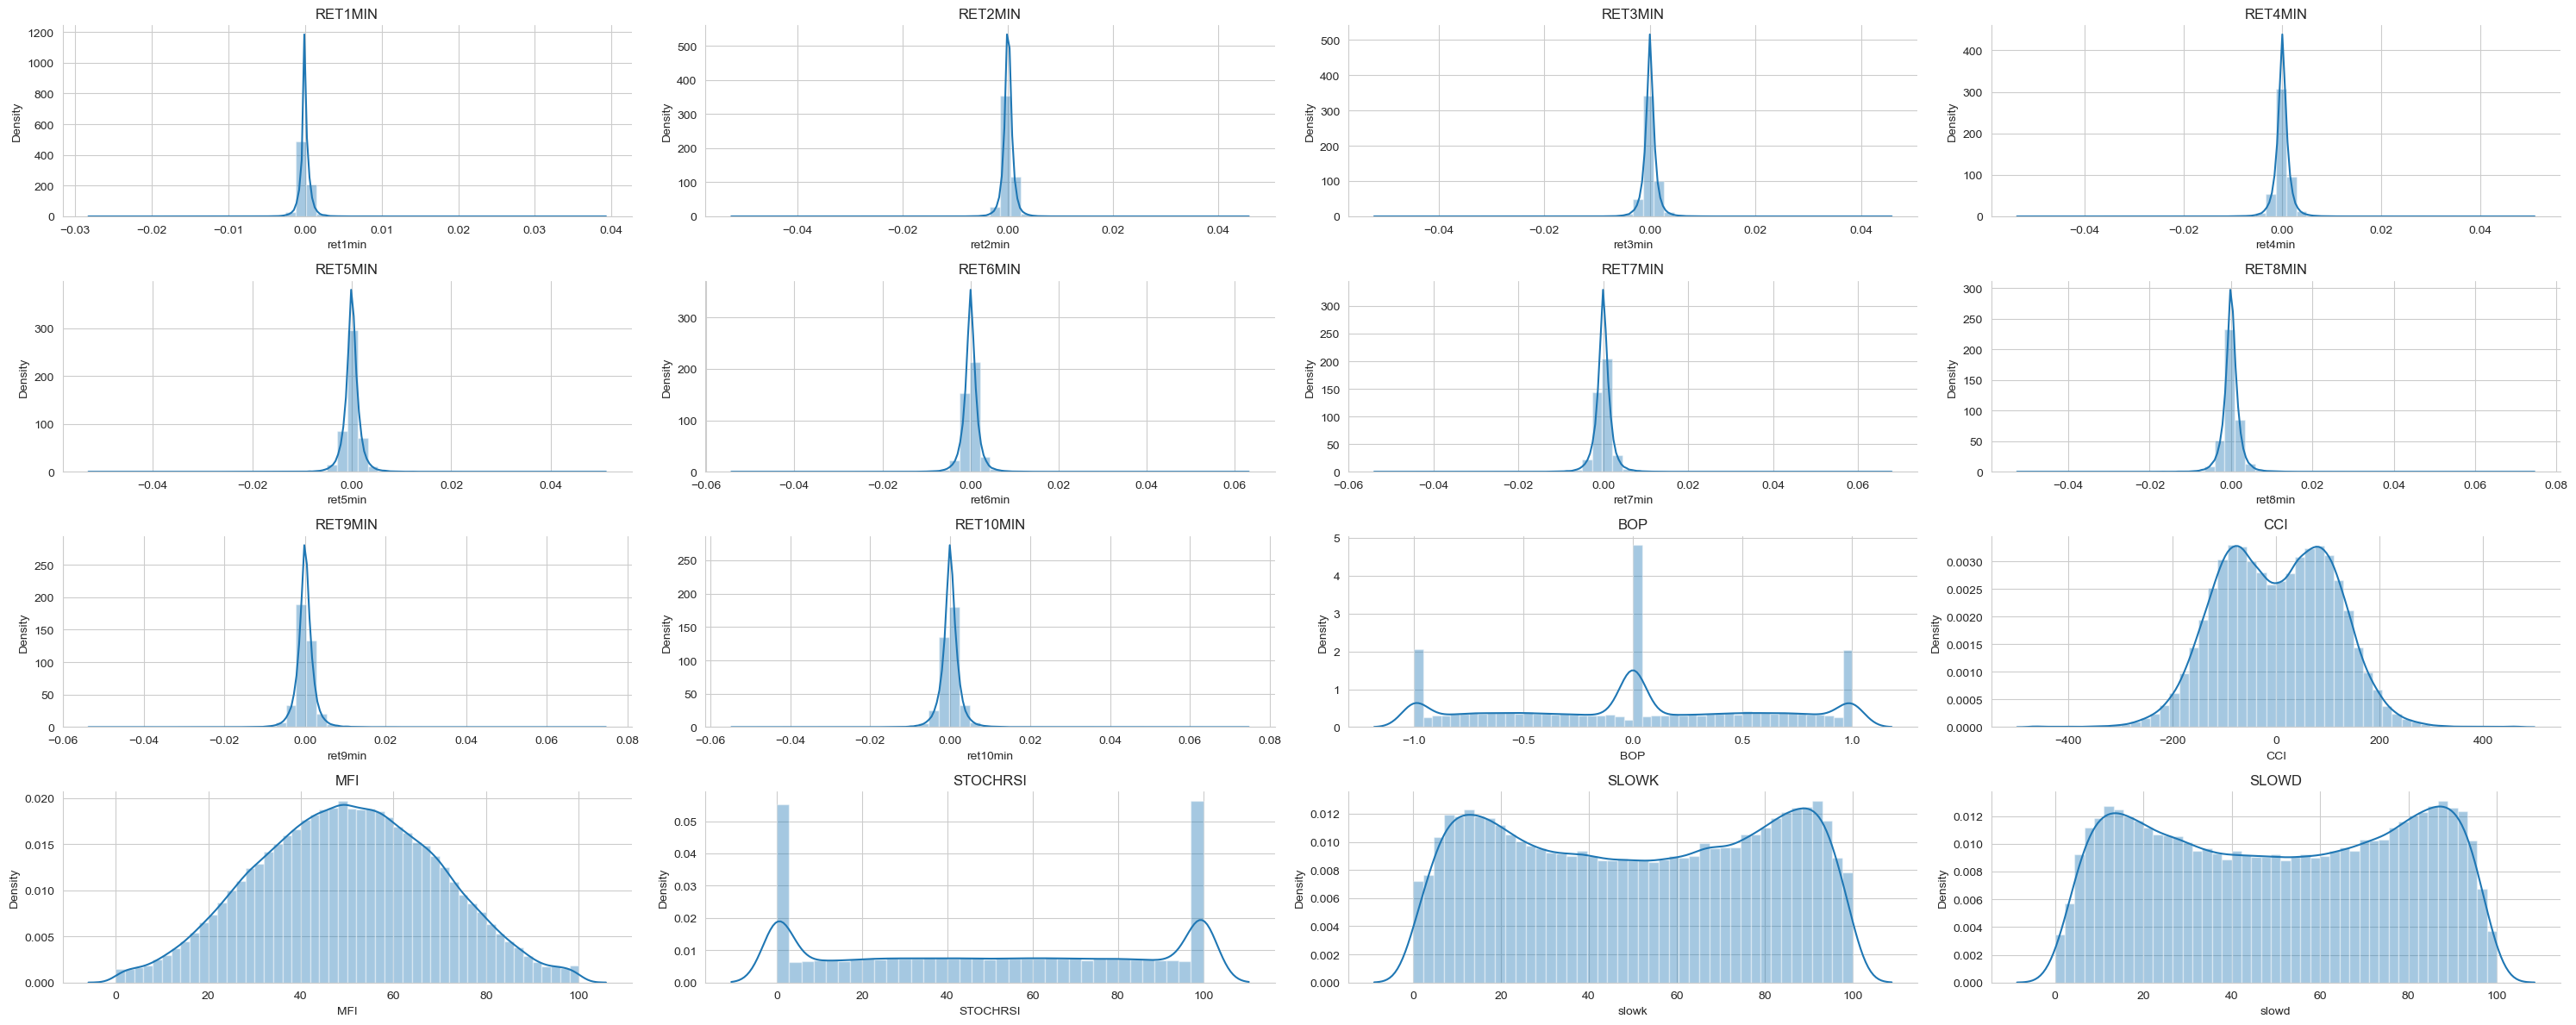

In [74]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

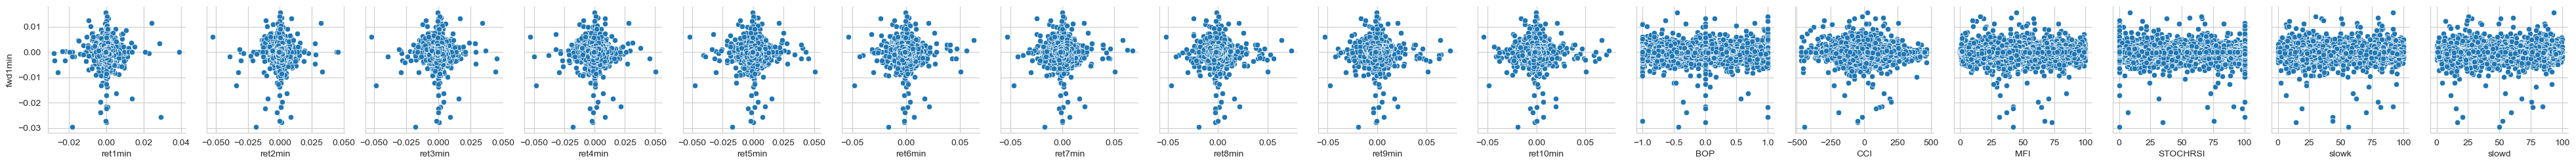

In [75]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features);

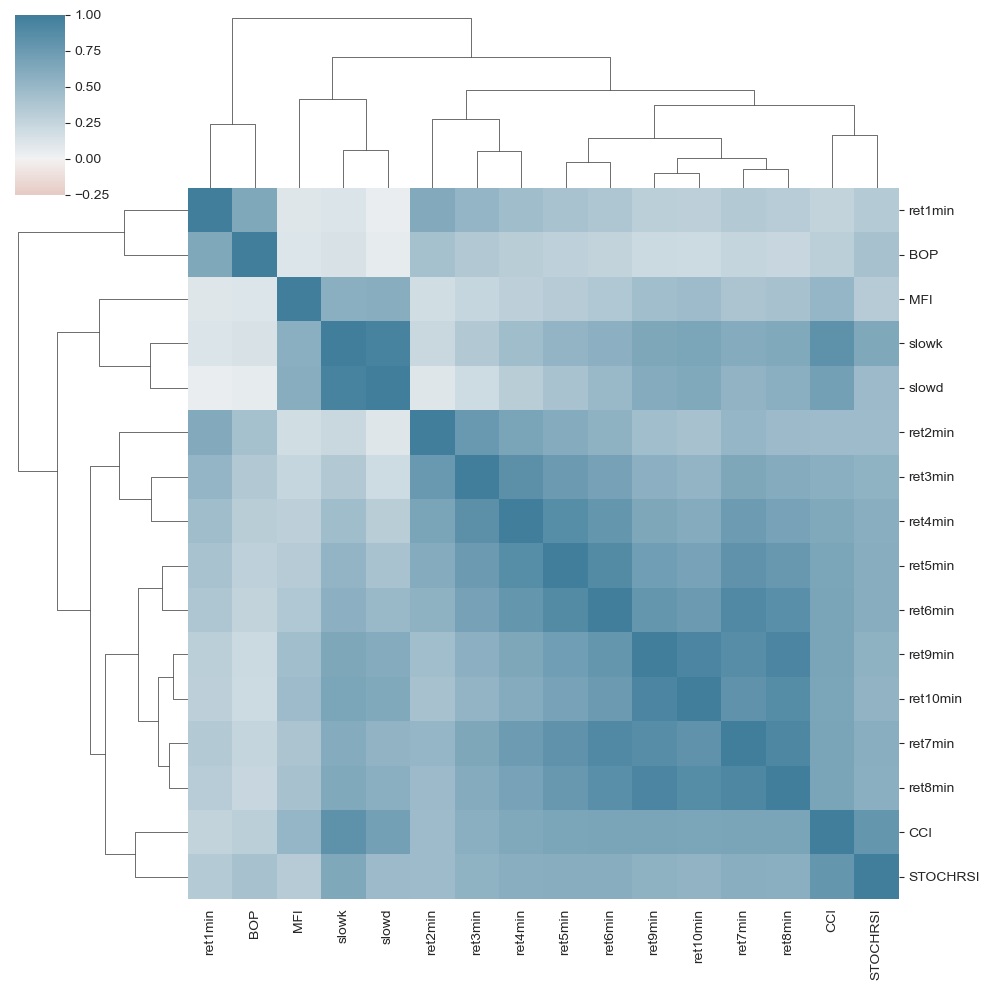

In [76]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [77]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('date_time').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


In [78]:
ic.sort_values()

MFI        -0.004118
ret9min    -0.003695
ret10min   -0.003254
ret8min    -0.003123
ret7min    -0.002798
slowd      -0.002009
slowk      -0.000807
ret6min    -0.000663
ret3min     0.000277
ret4min     0.000362
ret1min     0.000929
ret5min     0.000957
ret2min     0.001264
CCI         0.001553
BOP         0.003043
STOCHRSI    0.003697
dtype: float64

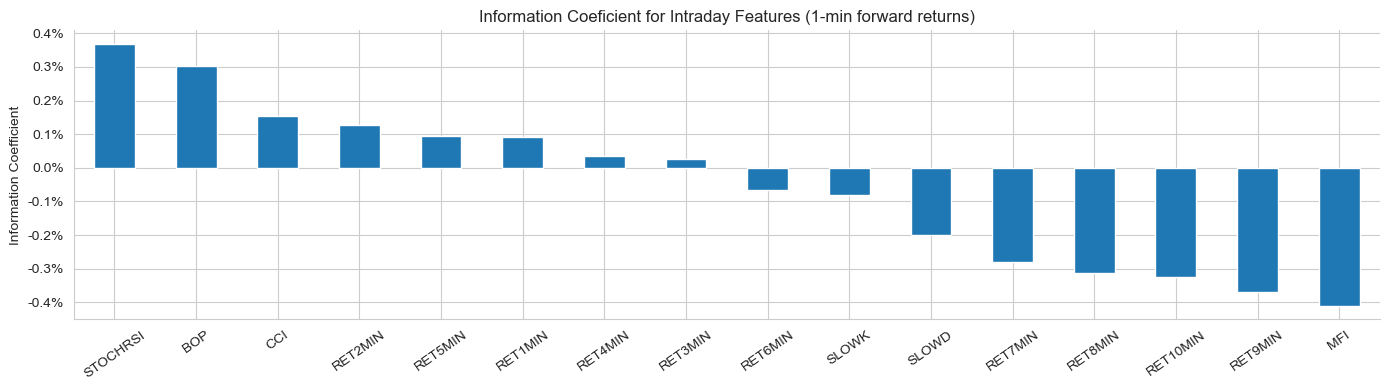

In [79]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

In [80]:
data.info(null_counts=True)

## main code has 5 more extra columns: up, down, rup, rdown, trade_bid_ask. We cant have those because of data constraints

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550464 entries, ('MSFT', Timestamp('2021-04-19 04:03:00')) to ('MSFT', Timestamp('2023-04-06 19:59:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      550464 non-null  int64  
 1   minute    550464 non-null  int32  
 2   ret1min   550464 non-null  float64
 3   ret2min   549470 non-null  float64
 4   ret3min   548476 non-null  float64
 5   ret4min   547482 non-null  float64
 6   ret5min   546488 non-null  float64
 7   ret6min   545494 non-null  float64
 8   ret7min   544500 non-null  float64
 9   ret8min   543506 non-null  float64
 10  ret9min   542512 non-null  float64
 11  ret10min  541518 non-null  float64
 12  fwd1min   550464 non-null  float64
 13  BOP       550464 non-null  float64
 14  CCI       550438 non-null  float64
 15  MFI       550436 non-null  float64
 16  STOCHRSI  550406 non-null  float64
 17  slowd     550430 non-null  float64
 18  slowk  

In [81]:
data = data.drop(['date'], axis=1)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550464 entries, ('MSFT', Timestamp('2021-04-19 04:03:00')) to ('MSFT', Timestamp('2023-04-06 19:59:00'))
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   minute    550464 non-null  int32  
 1   ret1min   550464 non-null  float64
 2   ret2min   549470 non-null  float64
 3   ret3min   548476 non-null  float64
 4   ret4min   547482 non-null  float64
 5   ret5min   546488 non-null  float64
 6   ret6min   545494 non-null  float64
 7   ret7min   544500 non-null  float64
 8   ret8min   543506 non-null  float64
 9   ret9min   542512 non-null  float64
 10  ret10min  541518 non-null  float64
 11  fwd1min   550464 non-null  float64
 12  BOP       550464 non-null  float64
 13  CCI       550438 non-null  float64
 14  MFI       550436 non-null  float64
 15  STOCHRSI  550406 non-null  float64
 16  slowd     550430 non-null  float64
 17  slowk     550430 non-null  float64
 18  NATR   